# Tutorial

In this tutorial we analyze the magnetic signal of a set of grains using Quantum Diamond Microscopy data and tomographic data. The former contains the magnetic signal of the grains and the latter both the position and geometry of every grain in the sample. The magnetic signal computed by the `DipoleCuboidInversion` class of this library is in units of field per sensor area, i.e. `Tesla * m^2`.

## Import base libraries

Before importing the main library we can set the maximum number of threads used by the library and the external libs such as Python and Scipy

In [1]:
from mmt_dipole_cuboid_inversion_config import set_max_num_threads
set_max_num_threads(6)

In [2]:
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import mmt_dipole_cuboid_inversion as dci

## Using the Dipole class

We first specify the location of the QDM scan data and the tomographic data with both the positions and dimensions of the cuboids. We define the scan surface area using the centers of the lower left and upper right sensors of the surface. For this we use the `QDM_sensor_domain` parameter. 

For the cuboid data, we will use a Numpy array instead of the raw text file, in order to modify the `z`-positions of the cuboids. The raw file is defined with the `z`-axis downwards (towards sample depth), but we will use the system with the axis pointing upwards. In the case we want to use the raw text file, we can define the `scan_height` variable as negative, i.e. `z=-6e-6` and the inversion will be made with a left-handed coordinate system, where `z` is oriented towards depth.

In [3]:
data_path = Path('../../chest/tutorial_qdm_data/')

# location and name of QDM and cuboid file
QDMfile = data_path / 'class_QDM_result2.txt'

# load cuboid data and redefine z-locations
cuboidfile = data_path / 'class_cuboid_result2.txt'
cuboiddata = np.loadtxt(cuboidfile, skiprows=0)
cuboiddata[:, 2] *= -1.0

# size of QDM domain
QDM_sensor_domain = np.array([[300, 1250], [450, 1400]]) * 1e-6
# Spacing between two QDM sample points
QDM_spacing = 1.2e-6
# half length of QDM sensor
QDM_deltax = 0.6e-6
# half width of QDM sensor
QDM_deltay = 0.6e-6
# area of QDM sensor
QDM_area = 1.44e-12
# distance between QDM and top sample
scan_height = 6e-6
# file to write magnetization grains to
# Magfile = data_path / "grain_mag.txt"

Now we can instantiate the class using the parameters defined previously. The first parameter in this class contains the locations of the sensor surface corners, however, here we will only use the positions of the sensors. Hence, we set the first parameter as `None`.

In [4]:
mag_svd = dci.DipoleCuboidInversion(
            None, QDM_sensor_domain, QDM_spacing, QDM_deltax, QDM_deltay, 
            QDM_area, scan_height)

Alternatively, we can load the scan surface parameters from a `json` file, which can be useful if we want to keep a record of the inversion parameters. Let's take a look at the `json` file for this tutorial first:

In [5]:
!cat ../../chest/tutorial_qdm_data/tutorial_scan_params.json

{"Sensor center domain LL-x-y": [0.0003, 0.00125], "Sensor center domain UR-x-y": [0.00045, 0.0014], "Scan spacing": 1.2e-06, "Scan delta-x": 6e-07, "Scan delta-y": 6e-07, "Scan area": 1.44e-12, "Scan height": 6e-06}


We can now use this configuration file to instatiate our class in a different way:

In [6]:
mag_svd = dci.DipoleCuboidInversion.from_json(data_path / 'tutorial_scan_params.json')

Now we can read the cuboid data (Numpy array) and the QDM file:

In [7]:
mag_svd.read_files(QDMfile, cuboiddata, cuboid_scaling_factor=1e-6)

and define the scan surface using two sensor locations:

In [8]:
mag_svd.set_scan_domain(gen_sd_mesh_from='sensor_center_domain')

We can check that the corner points defining the scan surface domain are slightly farther way from the centers of the sensors at the corners:

In [9]:
print(mag_svd.scan_domain * 1e6)

[[ 299.4 1249.4]
 [ 450.6 1400.6]]


## Inversion

To compute the magnetization we can use the shortcut fuction `obtain_magnetization` which calls three internal methods in the class. To populate the matrix we choose to use the `cython` method which fills the forward matrix `G` in parallel (much faster). The method to perform the numerical inversion can also be specified, in this case we use `pinv2` from Scipy which uses a Singular Value Decomposition for the pseudo-inverse:

In [10]:
mag_svd.obtain_magnetization(QDMfile, cuboiddata, cuboid_scaling_factor=1e-6,
                             method_populate='cython', method_inverse='scipy_pinv',
                             rtol=1e-30)

Start inversion with 15876 knowns and 297 unknowns
Inversion has been carried out


In [11]:
# An alternative method is to populate the matrix using the Numba optimised
# function
# mag_svd.obtain_magnetization(method_populate='numba', method_inverse='scipy_pinv2')

The forward matrix has the following form:

In [12]:
mag_svd.Forward_G

array([[-5.91128147e-24, -5.96524541e-24, -3.28667835e-23, ...,
        -9.12504624e-25, -4.51909283e-25, -2.02889537e-25],
       [-5.98821059e-24, -6.09719991e-24, -3.32948362e-23, ...,
        -9.34134404e-25, -4.68062466e-25, -1.98778780e-25],
       [-6.06554735e-24, -6.23201315e-24, -3.37282690e-23, ...,
        -9.56227406e-25, -4.84817836e-25, -1.94284212e-25],
       ...,
       [ 1.42618674e-20,  1.76272473e-20,  7.42037749e-21, ...,
         4.95023260e-25,  1.10721103e-24, -1.66483002e-25],
       [ 1.41739838e-20,  1.57806884e-20,  6.02978137e-21, ...,
         5.00092223e-25,  1.08893166e-24, -1.69691140e-25],
       [ 1.38631248e-20,  1.40364639e-20,  4.75211303e-21, ...,
         5.04684729e-25,  1.07061060e-24, -1.72862219e-25]])

## Results

We can directly plot the original scan data but in the next section we will use the more powerful plot tools from this library.

We start cehcking the limits of the magnetic data and restrict the colormap of the result to a suitable range of values. We scale the data by the sensor area to obtain the average flux magnitude within each sensor.

In [13]:
print(np.max(np.abs(mag_svd.scan_matrix / QDM_area)))

0.0002999198478622462


We can now use a magnitude of, for instance, `200e-6`

In [14]:
vlim = 200e-6

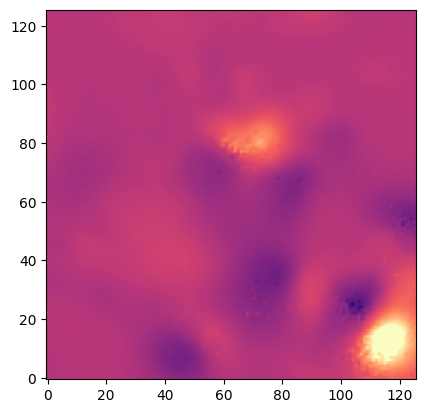

In [15]:
f, ax = plt.subplots()
ax.imshow(mag_svd.scan_matrix / QDM_area, origin='lower', cmap='magma',
          vmin=-vlim, vmax=vlim)
plt.show()

This is the field but inverted, we will plot this in the next section using the correct limits

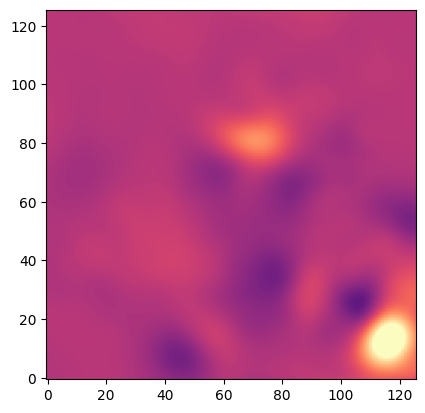

In [16]:
f, ax = plt.subplots()
ax.imshow((mag_svd.Forward_G @ mag_svd.Mag).reshape(mag_svd.Ny, -1) / QDM_area,
          vmin=-vlim, vmax=vlim,
          origin='lower', cmap='magma')
plt.show()

## Plots

The `mmt_dipole_inverse` library includes a powerful and modular way of generating plots from the inversion results and the cuboid/grain information.

In [17]:
from mmt_dipole_cuboid_inversion.tools import plot as dpi_pt

We first generate the corresponding arrays in the instance of the Dipole class, in this case we called it `mag_svd`. The `set_grain geometries` will create these arrays with information about the grain position and their dimensions. An useful argument is to scale the space by a factor, in this case we will set everything in micrometre units:

In [18]:
dpi_pt.set_grain_geometries(mag_svd, spatial_scaling=1e6)

We can, for example, plot the grain boundaries:

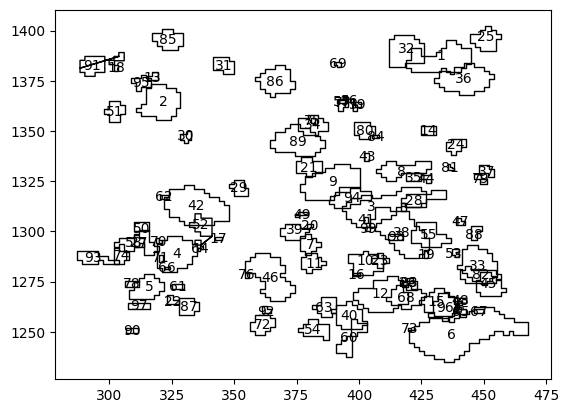

In [19]:
f, ax = plt.subplots()
dpi_pt.plot_grain_boundaries(mag_svd, ax)
plt.show()

But more useful is to combine this information with other plots. For example, we can first pot the grain boundaries and on top of it, we can plot the grains colored by their magnetization, which was computed with the Dipole class methods.
Moreover, we plot the inverted forward field in the background. We can do these operations pasing the same Matplotlib `axis`:

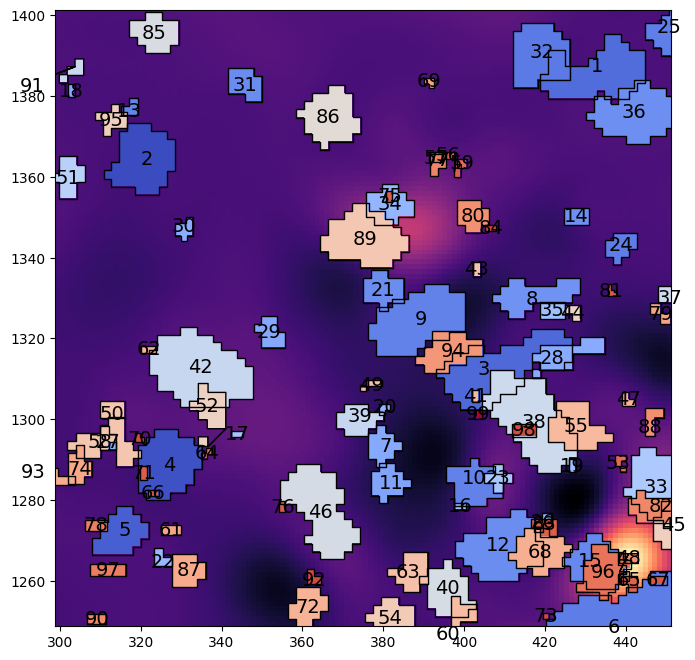

In [20]:
f, ax = plt.subplots(figsize=(8, 8))
dpi_pt.plot_magnetization_on_grains(mag_svd, ax, grain_labels=False)
dpi_pt.plot_grain_boundaries(mag_svd, ax, 
                             labels_args=dict(ha='center', va='center', fontsize=14))
dpi_pt.plot_inversion_field(mag_svd, ax)
plt.show()